# Descarga de dataset

In [1]:
# Seleccionar el API Token personal previamente descargado (fichero kaggle.json)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"enriqueguz1701","key":"7849cc978b31b3d3352bf37ecaffd791"}'}

In [2]:
# Creamos un directorio en el que copiamos el fichero kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!(kaggle datasets list -s sprites)

ref                                                              title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ebrahimelgazar/pixel-art                                         Pixel Art                                          86MB  2024-02-10 12:17:36           1286         30  1.0              
thecaptian/pokemon-sprites                                       Pokemon Sprites                                   288MB  2022-05-23 12:48:12             66          2  0.6875           
csalexi/animal-crossing-sprites                                  Animal Crossing Villager Sprites                  514MB  2022-02-11 04:08:17             25          8  0.5              
bhavyadhingra00020/complete-pokemon-dataset-9th-gen-img-tabular  

In [4]:
!kaggle datasets download -d ebrahimelgazar/pixel-art

Dataset URL: https://www.kaggle.com/datasets/ebrahimelgazar/pixel-art
License(s): apache-2.0
100% 85.7M/85.7M [00:05<00:00, 23.6MB/s]
100% 85.7M/85.7M [00:05<00:00, 16.7MB/s]


In [5]:
# Creemos un directorio para descomprimir los datos
!mkdir sprites

In [6]:
# Descomprimimos los datos y los dejamos listos para trabajar
%%capture
!unzip pixel-art.zip -d sprites

In [7]:
!ls sprites

images	labels.csv  sprites_labels.npy	sprites.npy


# Imports

In [8]:
import numpy as np
import os
import cv2

from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from tensorflow.keras import layers

# Sprites

In [9]:
image_size = 32
batch_size = 164
timesteps = 16    # how many steps for a noisy image into clear
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # linspace for timesteps

In [10]:
# Cargar las imágenes desde sprites.npy
images = np.load('sprites/sprites.npy')

# Crear carpeta de destino si no existe
output_folder = 'sprites/sprites_png'
os.makedirs(output_folder, exist_ok=True)

# Guardar cada imagen
for i, img_array in enumerate(images):
    # Verifica si img_array tiene rango [-1, 1] o [0, 1] y normaliza a [0, 255]
    if img_array.min() < 0:  # Caso normalizado [-1, 1]
        img_array = ((img_array + 1) * 127.5).astype('uint8')
    elif img_array.max() <= 1:  # Caso normalizado [0, 1]
        img_array = (img_array * 255).astype('uint8')
    else:  # Si ya está en [0, 255]
        img_array = img_array.astype('uint8')

    # Convierte de RGB a BGR antes de guardar con OpenCV
    img_bgr = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)

    # Guardar la imagen
    output_path = os.path.join(output_folder, f'image_{i}.png')
    cv2.imwrite(output_path, img_bgr)

print(f'Todas las imágenes se guardaron en la carpeta: {output_folder}')


Todas las imágenes se guardaron en la carpeta: sprites/sprites_png


In [11]:
images = keras.utils.image_dataset_from_directory(
    'sprites/sprites_png/',labels=None, label_mode=None, color_mode='rgb', image_size=(image_size,image_size), batch_size=batch_size
)
images = images.map(lambda x:(x/127.5)-1)

Found 89400 files.


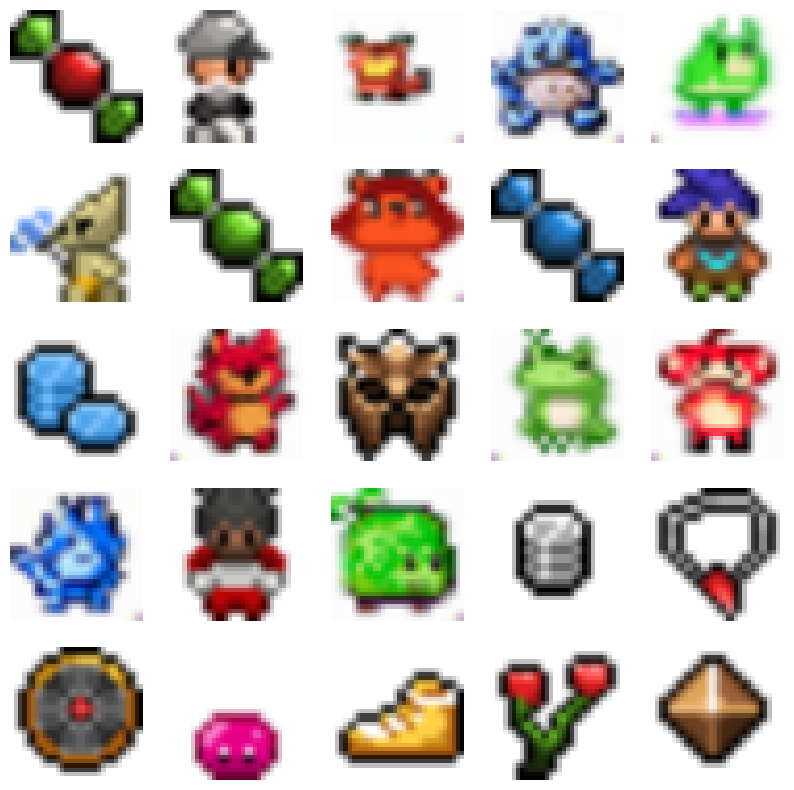

In [12]:
def cvtImg(img):
    img = img - img.min()
    img = (img / img.max())
    return img.astype(np.float32)

def show_examples(x):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img = cvtImg(x[i])
        plt.imshow(img)
        plt.axis('off')

# Extraer un lote para visualización
for batch in images.take(1):  # Toma el primer lote
    batch_np = batch.numpy()  # Convierte a numpy array
    show_examples(batch_np)

# Modelo de difusión

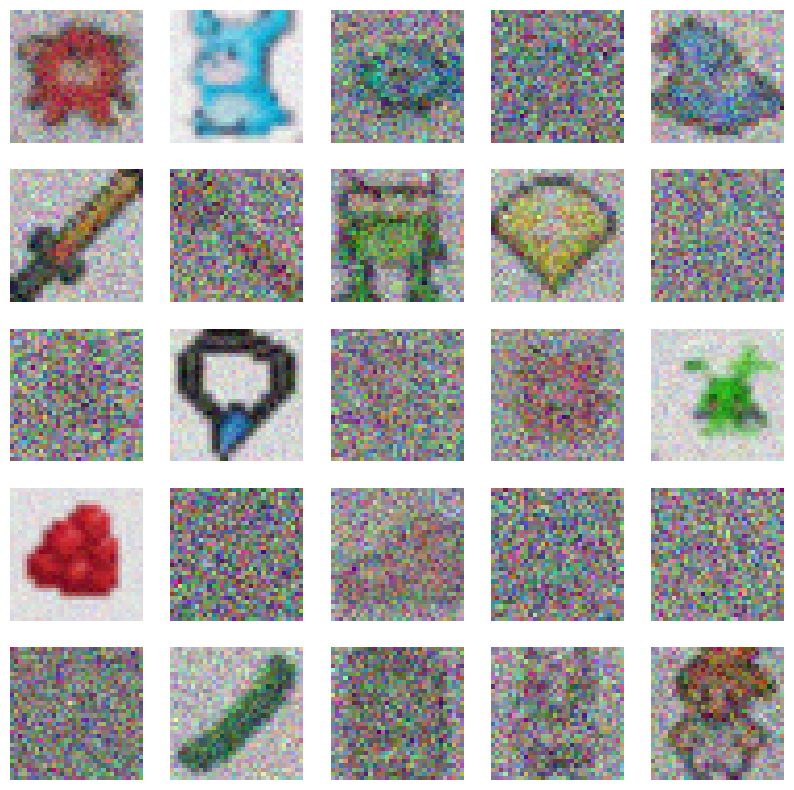

In [13]:
def forward_noise(x, t):
    a = time_bar[t]      # base on t
    b = time_bar[t + 1]  # image for t + 1

    noise = np.random.normal(size=x.shape)  # noise mask
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b

def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

# Extraer imágenes del dataset
for batch in images.take(1):  # Obtén el primer lote de imágenes
    batch_np = batch.numpy()  # Convierte el lote a array NumPy
    t = generate_ts(25)       # Genera índices de tiempo aleatorios
    a, b = forward_noise(batch_np[:25], t)  # Aplica forward_noise a 25 imágenes
    show_examples(a)  # Visualiza las imágenes con ruido

In [14]:
def block(x_img, x_ts):
    x_parameter = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    x_parameter = layers.Activation('relu')(x_parameter)

    time_parameter = layers.Dense(128)(x_ts)
    time_parameter = layers.Activation('relu')(time_parameter)
    time_parameter = layers.Reshape((1, 1, 128))(time_parameter)
    x_parameter = x_parameter * time_parameter

    # -----
    x_out = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    x_out = x_out + x_parameter
    x_out = layers.LayerNormalization()(x_out)
    x_out = layers.Activation('relu')(x_out)

    return x_out

def make_model():
    x = x_input = layers.Input(shape=(image_size, image_size, 3), name='x_input')

    x_ts = x_ts_input = layers.Input(shape=(1,), name='x_ts_input')
    x_ts = layers.Dense(192)(x_ts)
    x_ts = layers.LayerNormalization()(x_ts)
    x_ts = layers.Activation('relu')(x_ts)

    # ----- left ( down ) -----
    x = x32 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)

    x = x16 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)

    x = x8 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)

    x = x4 = block(x, x_ts)

    # ----- MLP -----
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, x_ts])
    x = layers.Dense(128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Dense(4 * 4 * 32)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((4, 4, 32))(x)

    # ----- right ( up ) -----
    x = layers.Concatenate()([x, x4])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x8])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x16])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x32])
    x = block(x, x_ts)

    # ----- output -----
    x = layers.Conv2D(3, kernel_size=1, padding='same')(x)
    model = tf.keras.models.Model([x_input, x_ts_input], x)
    return model

model = make_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ x_ts_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 192)            │            384 │ x_ts_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 192)            │            384 │ dense[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 192)            │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x_input (InputLayer)      │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         24,704 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 128)    │          3,584 │ x_input[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 128)    │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 128)      │              0 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 128)    │          3,584 │ x_input[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 32, 32, 128)    │              0 │ activation_1[0][0],    │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 128)    │              0 │ conv2d_1[0][0],        │
│                           │                        │                │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 32, 32, 128)    │            256 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 32, 32, 128)    │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         24,704 │ activation[0][0]       │
├──────────────────────

 Total params: 3,586,819 (13.68 MB)

 Trainable params: 3,586,819 (13.68 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
loss_func = tf.keras.losses.MeanAbsoluteError()
model.compile(loss=loss_func, optimizer=optimizer)

  0%|          | 0/16 [00:00<?, ?it/s]

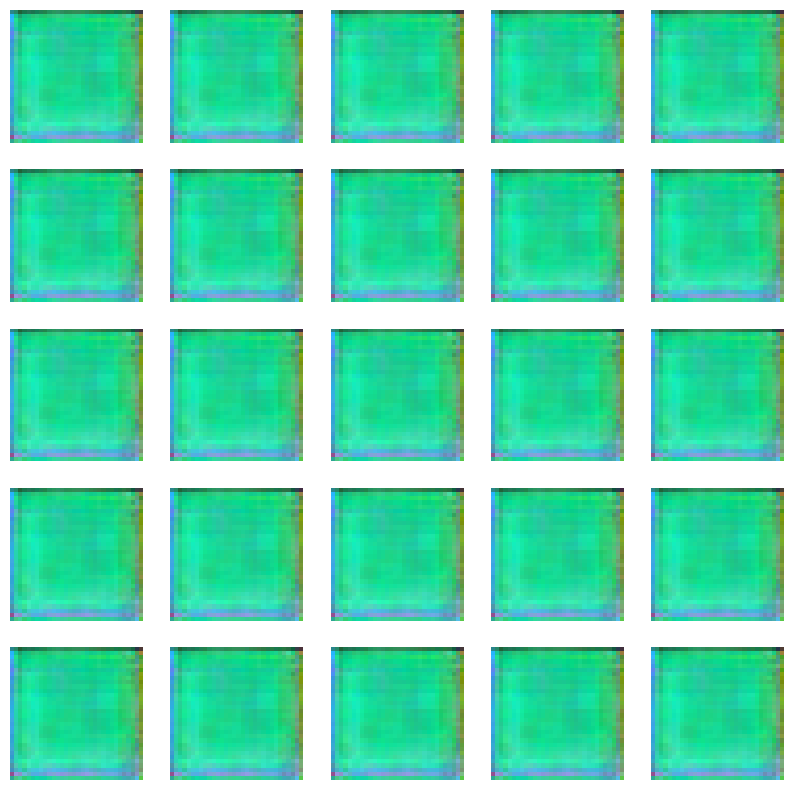

In [16]:
def predict(x_idx=None):
    x = np.random.normal(size=(32, image_size, image_size, 3))
    for i in trange(timesteps):
        t = i
        x = model.predict([x, np.full((32), t)], verbose=0)
    show_examples(x)

predict()

  0%|          | 0/16 [00:00<?, ?it/s]

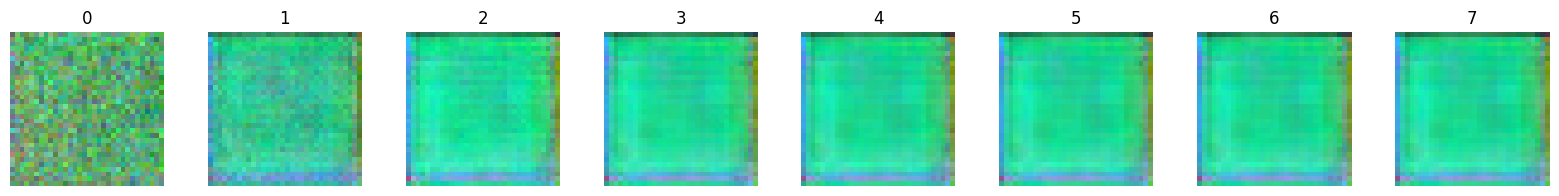

In [17]:
def predict_step():
    xs = []
    x = np.random.normal(size=(8, image_size, image_size, 3))

    for i in trange(timesteps):
        t = i
        x = model.predict([x, np.full((8),  t)], verbose=0)
        if i % 2 == 0:
            xs.append(x[0])

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(cvtImg(xs[i]))
        plt.title(f'{i}')
        plt.axis('off')

predict_step()

In [18]:
def train_one(x_img):
    x_ts = generate_ts(len(x_img))
    x_a, x_b = forward_noise(x_img, x_ts)
    loss = model.train_on_batch([x_a, x_ts], x_b)
    return loss

In [19]:
def train(R=50):
    bar = trange(R)
    total = 100
    for i in bar:
        dataset_iter = iter(images)
        for j in range(total):
            # Extraer un lote aleatorio
            try:
                x_img = next(dataset_iter)  # Extrae un lote de imágenes
            except StopIteration:
                dataset_iter = iter(images)  # Reinicia el iterador si se agota
                x_img = next(dataset_iter)

            x_img = x_img.numpy()  # Convierte a numpy para pasar a train_one
            loss = train_one(x_img)  # Calcula la pérdida para el lote
            pg = (j / total) * 100
            if j % 5 == 0:
                bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

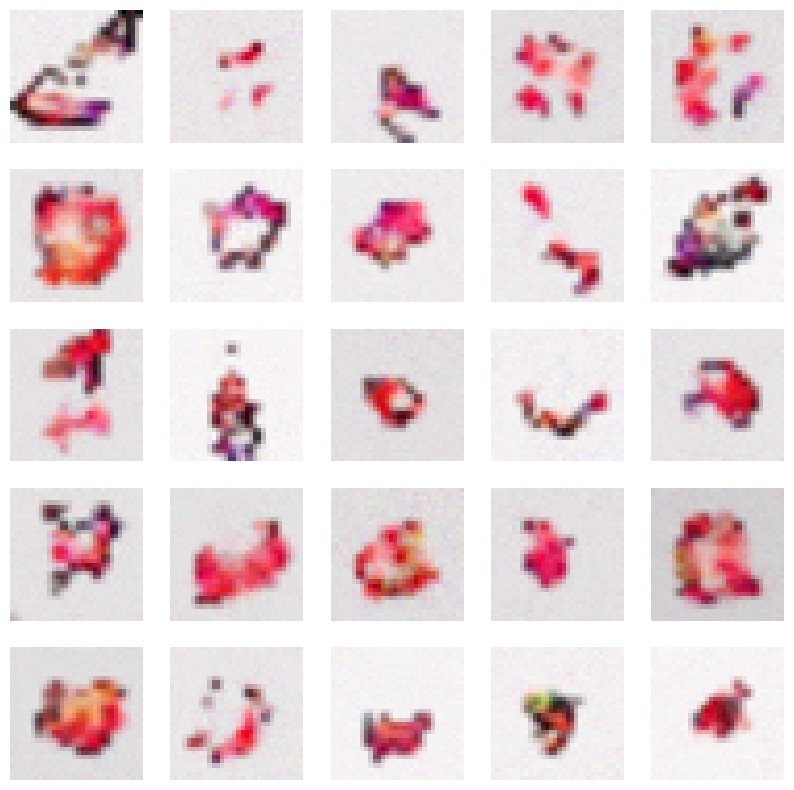

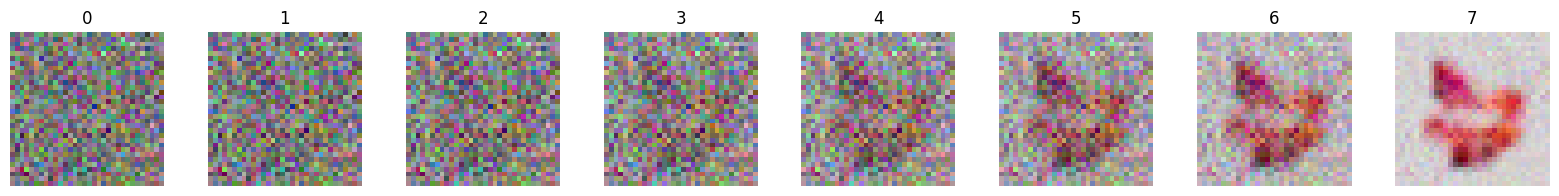

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

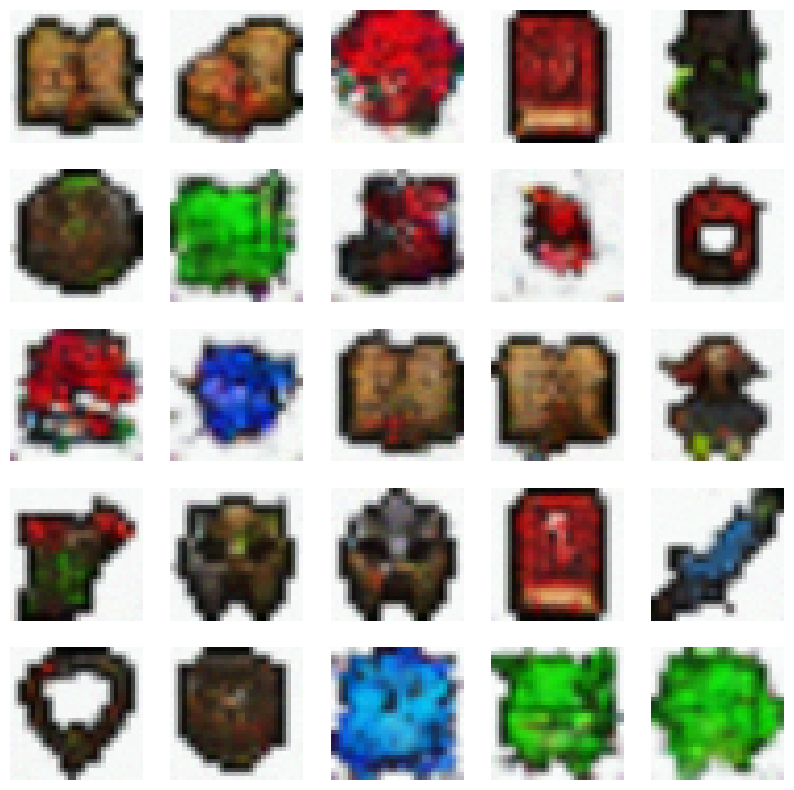

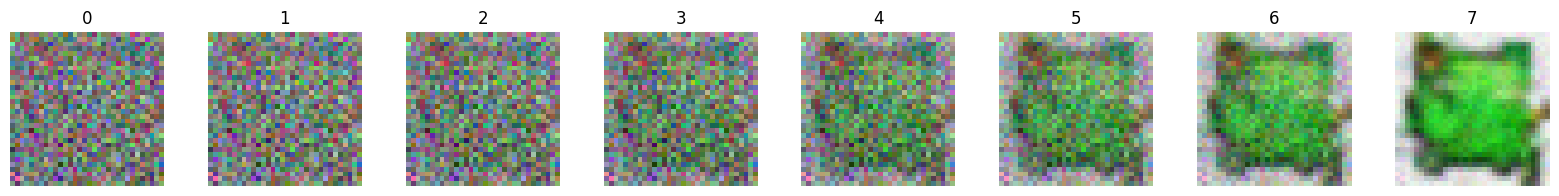

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

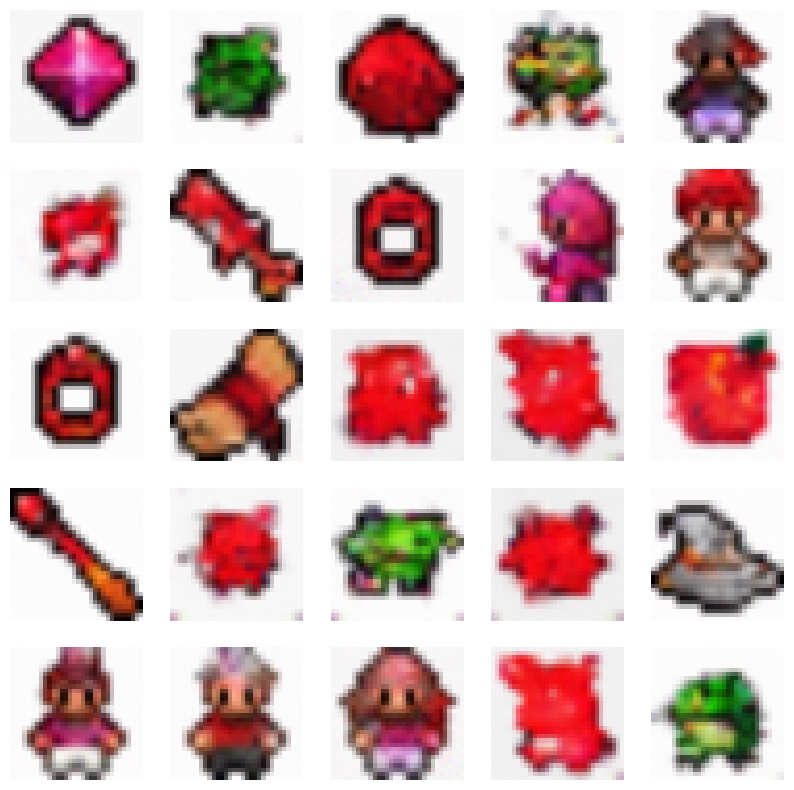

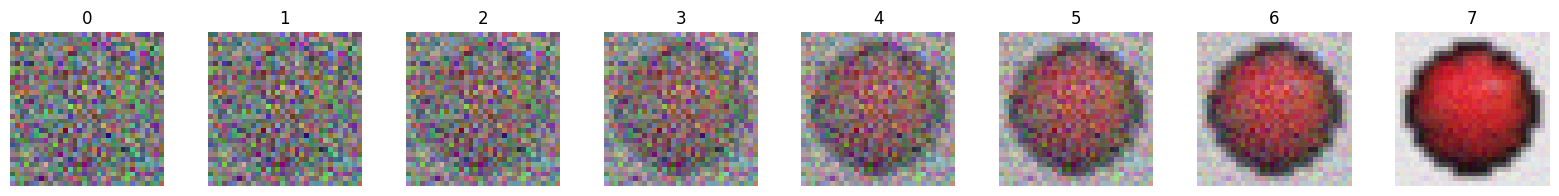

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

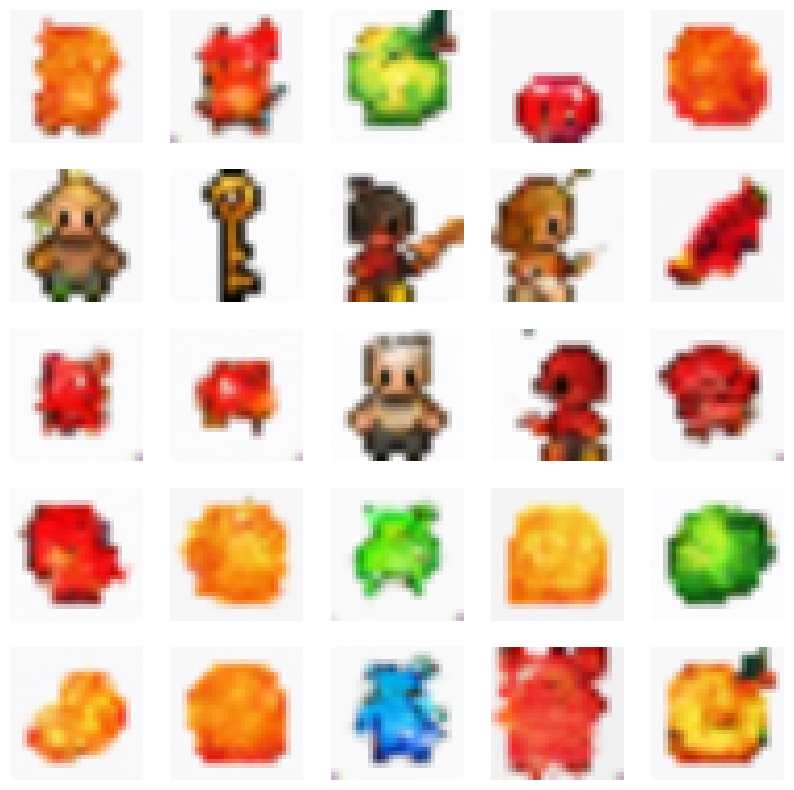

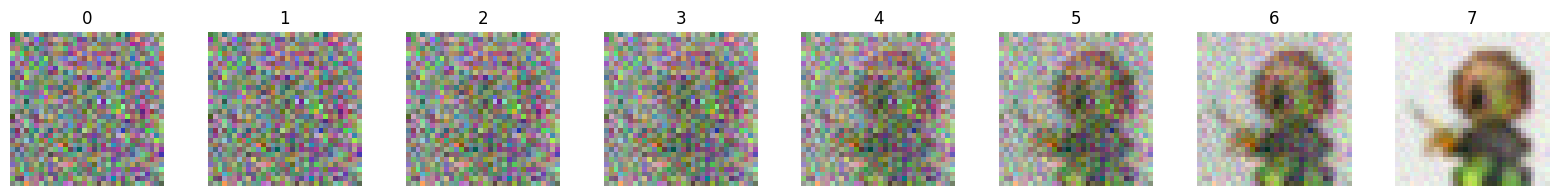

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

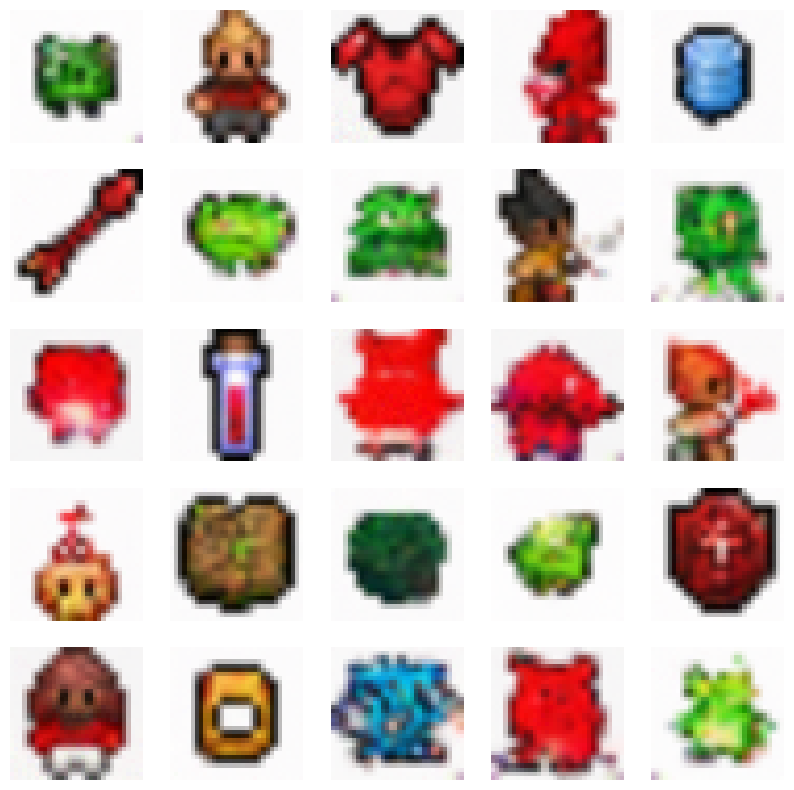

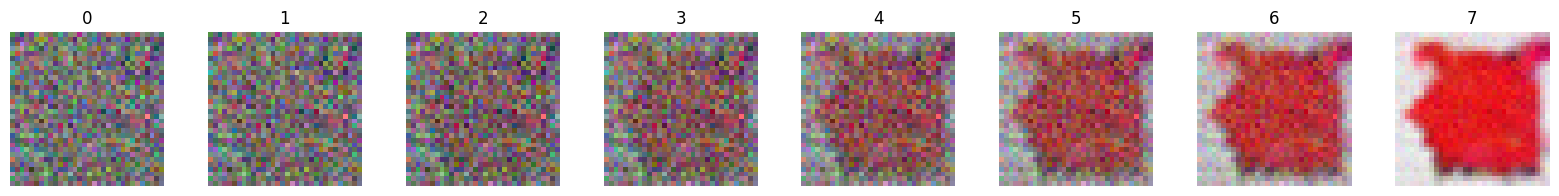

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

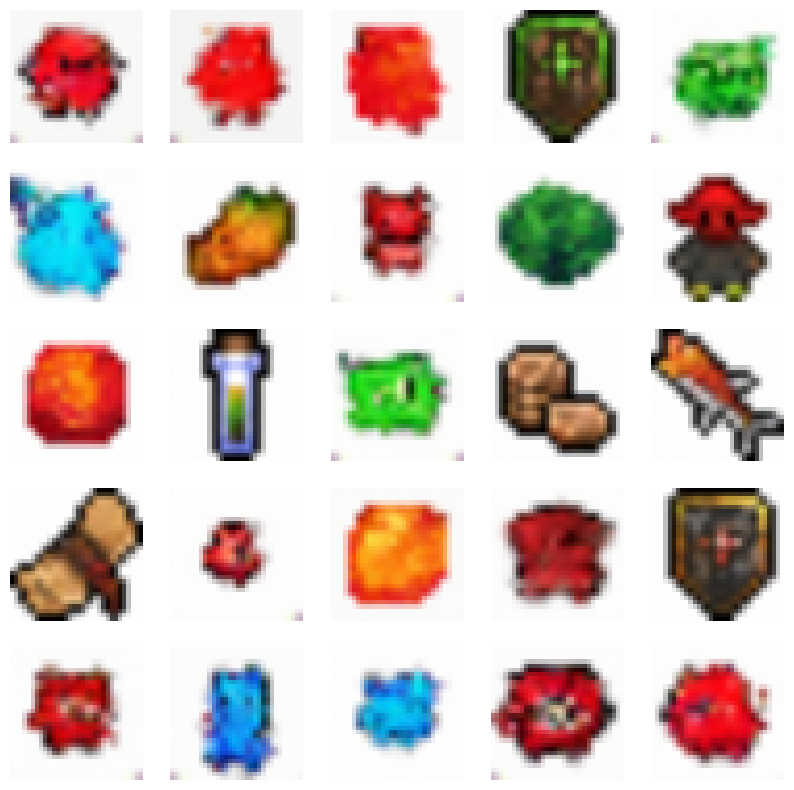

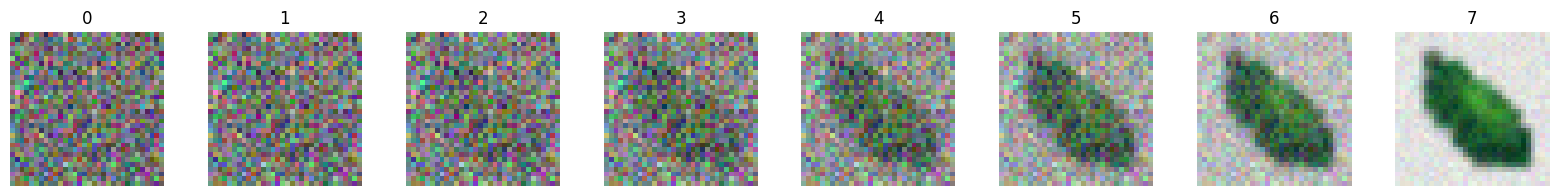

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

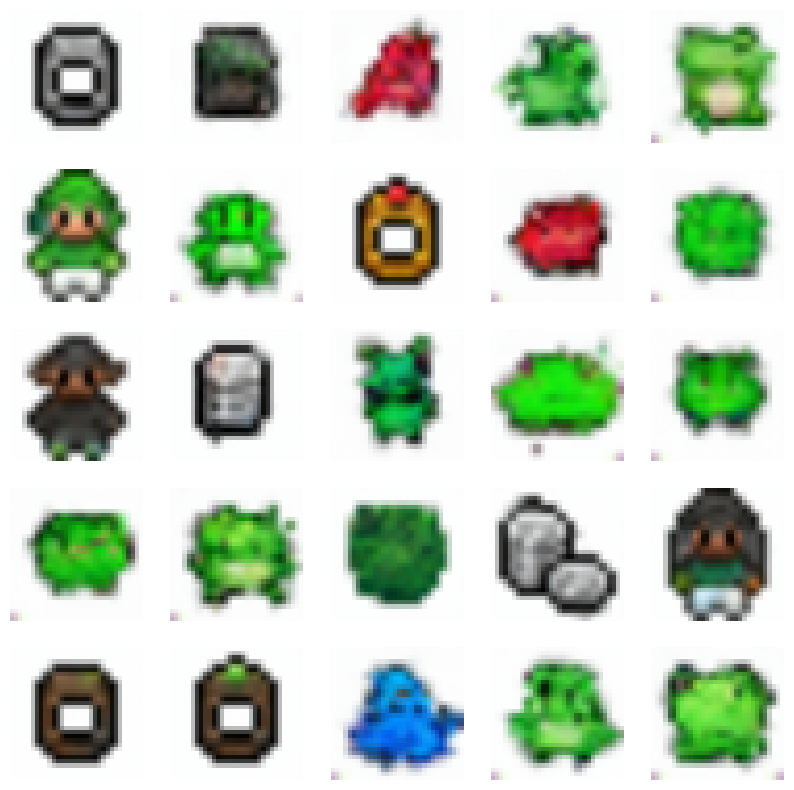

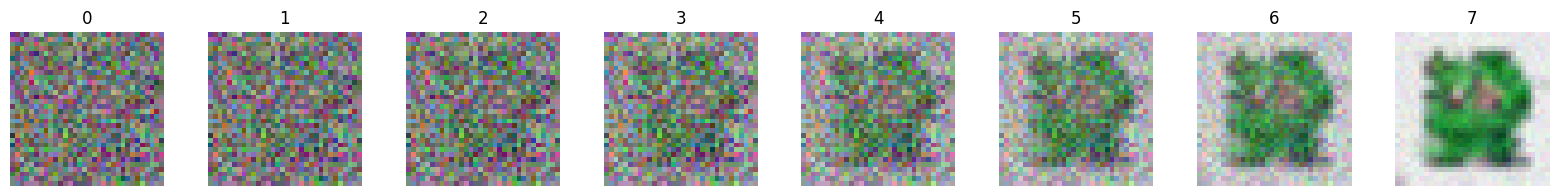

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

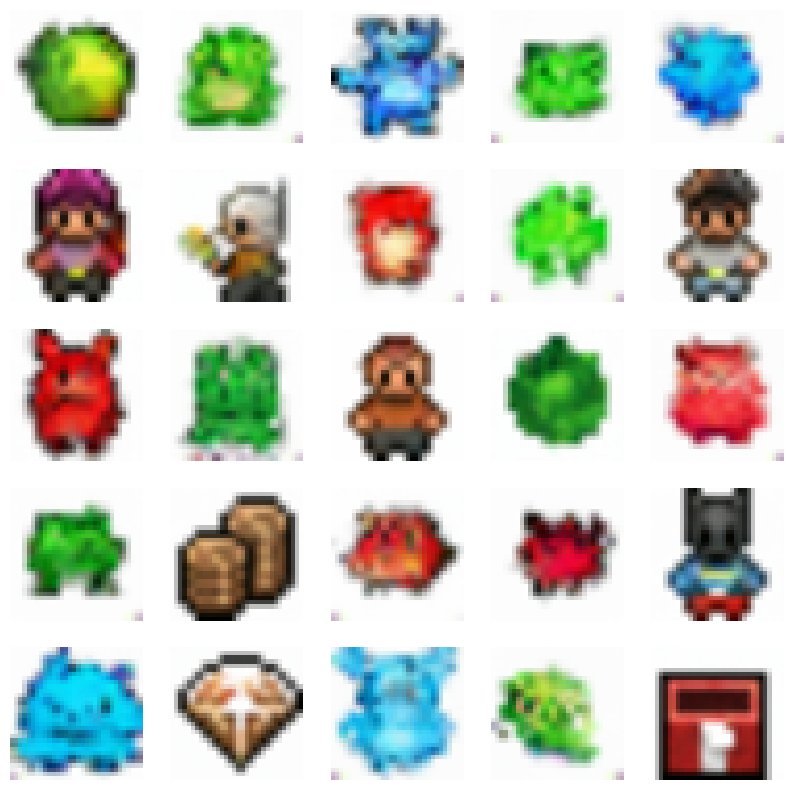

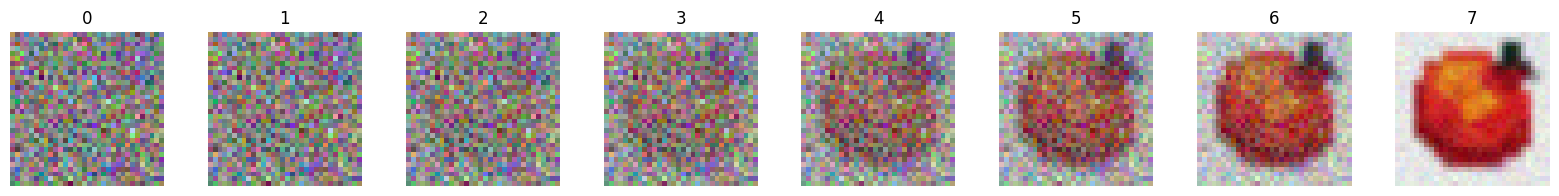

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

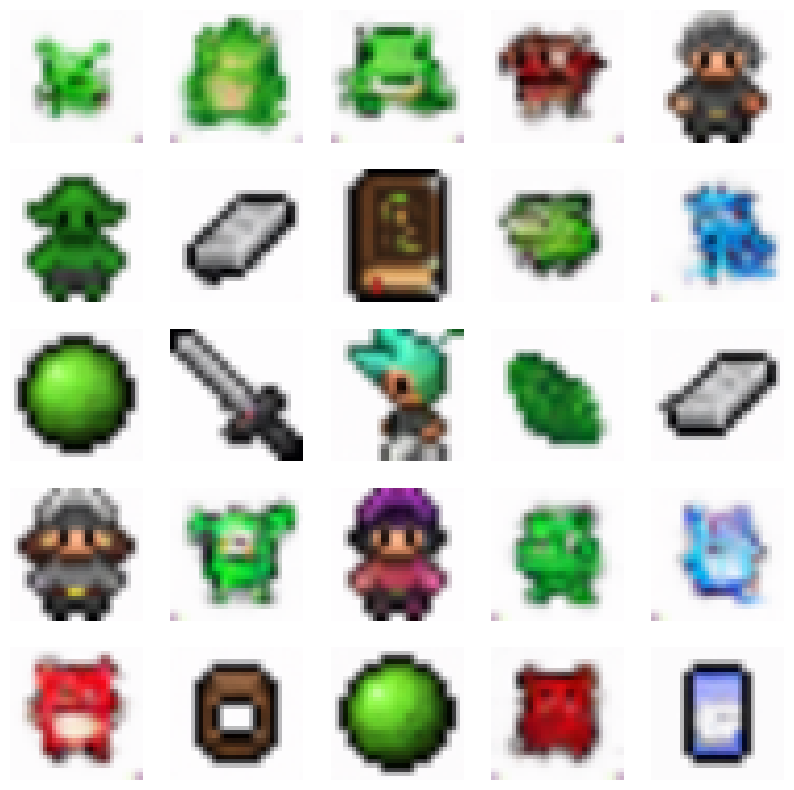

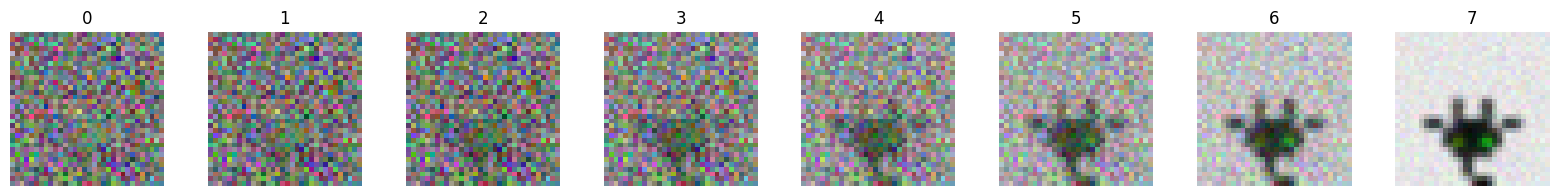

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

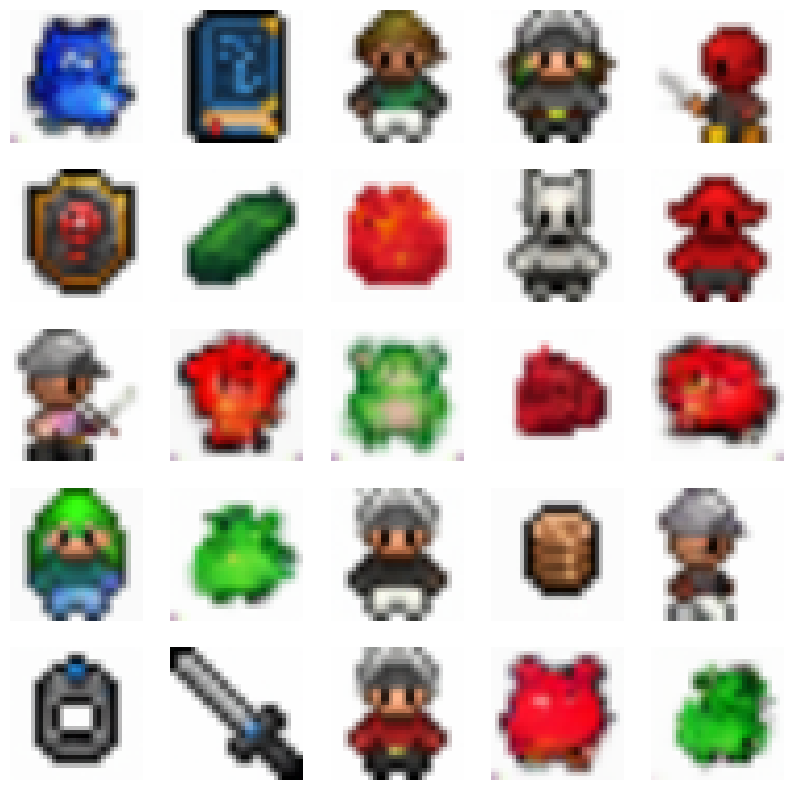

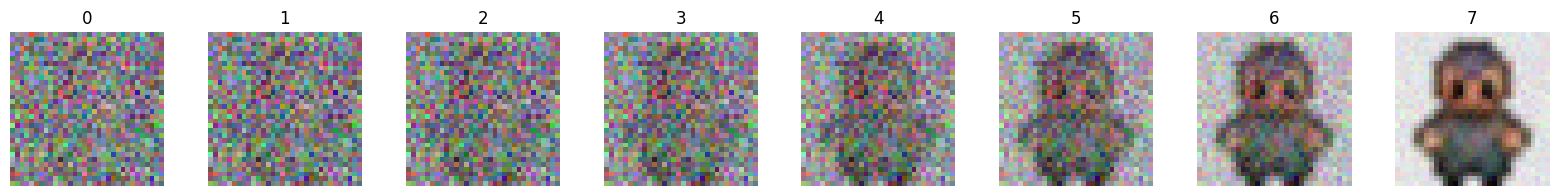

In [20]:
for _ in range(10):
    train()
    # reduce learning rate for next training
    model.optimizer.learning_rate = max(0.000001, model.optimizer.learning_rate * 0.9)

    # show result
    predict()
    predict_step()
    plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]

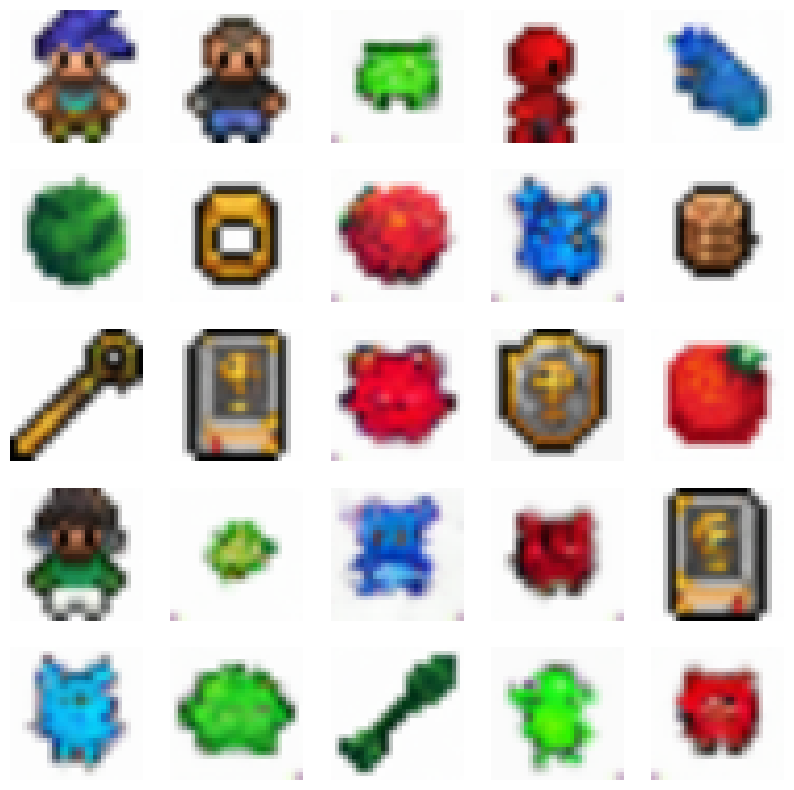

In [21]:
predict()

  0%|          | 0/16 [00:00<?, ?it/s]

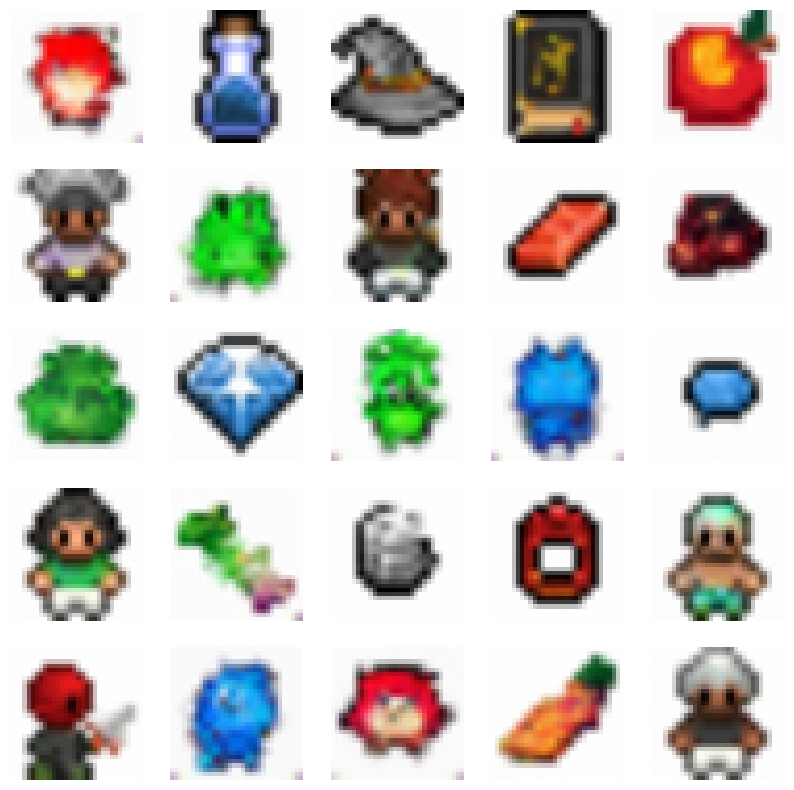

In [22]:
predict()